In [10]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json   
import datetime
import folium
from haversine import haversine

# 판다스 기본설정
pd.set_option('display.max_columns', 6)

# 그래프 출력 설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [12]:
# data 불러오기
df = pd.read_csv("data/listings.csv")
df

,id,listing_url,scrape_id,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20211228000752,...,0,0,1.32
1,776070,https://www.airbnb.com/rooms/776070,20211228000752,...,1,0,2.06
2,1196177,https://www.airbnb.com/rooms/1196177,20211228000752,...,1,0,0.93
3,1249571,https://www.airbnb.com/rooms/1249571,20211228000752,...,0,0,1.01
4,1263000,https://www.airbnb.com/rooms/1263000,20211228000752,...,1,0,1.79
...,...,...,...,...,...,...,...
10309,53975652,https://www.airbnb.com/rooms/53975652,20211228000752,...,0,0,NaN
10310,53975823,https://www.airbnb.com/rooms/53975823,20211228000752,...,0,0,NaN
10311,53977613,https://www.airbnb.com/rooms/53977613,20211228000752,...,0,0,NaN
10312,53986067,https://www.airbnb.com/rooms/53986067,20211228000752,...,0,0,NaN


In [3]:
# data 불러오기
df = pd.read_csv("data/listings.csv")

# 모든 값이 결측값인 변수 제거
df = df.drop(columns = df.columns[df.isna().sum() == len(df)].tolist())

# 자료형 변환

# 숫자형으로 저장된 범주형 변수 문자형으로 변환
df["id"] = df["id"].apply(lambda x : str(x))
df["host_id"] = df["host_id"].apply(lambda x : str(x))
df["scrape_id"] = df["scrape_id"].apply(lambda x : str(x))


# 시간형 변수들의 자료형 변환 (object to datetime)
to_datetime_columns= ["last_scraped", "host_since", "calendar_last_scraped", "first_review", "last_review"]
for column in to_datetime_columns:
    df[column] = pd.to_datetime(df[column])
del to_datetime_columns    

# 응답률의 퍼센트 단위제거
remove_percent_columns = ["host_response_rate", "host_acceptance_rate"]
for column in remove_percent_columns:
    df[column] = df[column].apply(lambda x : x if x is np.nan else int(x.replace("%", ""))/100)
del remove_percent_columns    

# 가격의 ($)와 콤마 제거
df["price"] = df["price"].apply(lambda x : float(x[1:].replace(",", "")))

# 가격의 단위 한화로 수정 (2022.04.29 20:00 기준 엔화 -> 한화)
df["price"] = df["price"].apply(lambda x : int(x * 9.679))

# 이상치 제거

# 숙소의 가격이 0 인 경우 제거
df = df[df["price"]!=0]

# 숙소의 가격 극단 이상값 제거 (Q3 에서 2 step 이상인 값 제거)
IQR = (df["price"].describe()["75%"] - df["price"].describe()["25%"]) * 1.5
print(f"숙소의 가격이 {df['price'].describe()['75%'] + 2 * IQR}원 이상인 숙소는 제거")
df = df[df["price"] < df["price"].describe()["75%"] + 2 * IQR]

# 인덱스 초기화
df = df.reset_index(drop = True)

숙소의 가격이 511178.0원 이상인 숙소는 제거


In [4]:
df

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20211228000752,2021-12-28,Oshiage Holiday Apartment,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,https://www.airbnb.com/users/show/964081,Yoshimi & Marek,2011-08-13,Tokyo,Would love to travel all over the world and me...,within a day,1.00,1.0,f,https://a0.muscache.com/im/users/964081/profil...,https://a0.muscache.com/im/users/964081/profil...,Sumida District,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,f,NaN,Sumida Ku,35.717070,139.826080,Entire rental unit,Entire home/apt,4,1 bath,1.0,2.0,"[""Dedicated workspace"", ""Long term stays allow...",106469,3,365,3.0,3.0,365.0,365.0,3.0,365.0,t,28,58,88,363,2021-12-28,165,0,0,2011-09-21,2020-03-04,4.76,4.73,4.91,4.83,4.82,4.51,4.78,M130003350,f,1,1,0,0,1.32
1,776070,https://www.airbnb.com/rooms/776070,20211228000752,2021-12-28,Kero-kero house room 1,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,https://www.airbnb.com/users/show/801494,Kei,2011-07-10,Japan,Love culture/foods/anime and to know about oth...,NaN,NaN,NaN,t,https://a0.muscache.com/im/pictures/user/ba6d4...,https://a0.muscache.com/im/pictures/user/ba6d4...,Kita District,1.0,1.0,"['email', 'phone', 'manual_online', 'reviews',...",t,t,"Kita-ku, Tokyo, Japan",Kita Ku,35.738440,139.769170,Private room in residential home,Private room,2,1 shared bath,1.0,1.0,"[""TV with standard cable"", ""Wifi"", ""Dishes and...",77693,3,14,3.0,3.0,14.0,14.0,3.0,14.0,t,17,47,77,257,2021-12-28,228,0,0,2012-11-28,2020-01-18,4.97,4.96,4.92,4.97,4.97,4.84,4.91,M130000243,f,1,0,1,0,2.06
2,1196177,https://www.airbnb.com/rooms/1196177,20211228000752,2021-12-28,Stay with host Cozy private room Senju area,Ｓtay with host.We can help your travel.<br />B...,There are shopping mall near Senjuohashi stati...,https://a0.muscache.com/pictures/72890882/05ec...,5686404,https://www.airbnb.com/users/show/5686404,Yukiko,2013-03-30,"Adachi City, Tokyo, Japan",出身地 東京\r\n好きなこと 旅行､ﾃﾆｽ\r\n\r\nA host is the hu...,within a day,1.00,0.0,t,https://a0.muscache.com/im/users/5686404/profi...,https://a0.muscache.com/im/users/5686404/profi...,Adachi District,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"足立区, 東京都, Japan",Adachi Ku,35.744750,139.797310,Private room in residential home,Private room,2,1 shared bath,1.0,2.0,"[""Dedicated workspace"", ""Long term stays allow...",387160,2,30,2.0,2.0,1125.0,1125.0,2.0,1125.0,t,28,58,88,88,2021-12-28,95,0,0,2013-08-10,2020-03-17,4.71,4.87,4.75,4.92,4.88,4.67,4.75,M130007760,f,1,0,1,0,0.93
3,1249571,https://www.airbnb.com/rooms/1249571,202112280007

In [761]:
# 지역별 숙소의 개수 시각화
latitude, longitude = (35.72182255318591, 139.53801614242826)
map = folium.Map(location=[latitude, longitude], 
                zoom_start=10)
with open("data/summary_file/neighbourhoods.geojson",'r') as json_file:             
    tokyo_geo = json.load(json_file)

folium.GeoJson(
    tokyo_geo,
    name='지역구'
).add_to(map)

tokyo_group_data = df.groupby("neighbourhood_cleansed").count()["id"]

map.choropleth(geo_data=tokyo_geo,
             data=tokyo_group_data, 
             fill_color='YlOrRd', # 색상 변경도 가능하다
             fill_opacity=0.5,
             line_opacity=0.2,
             key_on="properties.neighbourhood",
             legend_name= "neb"
            )

map                       

C:\Users\havea\anaconda3\envs\cp1\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


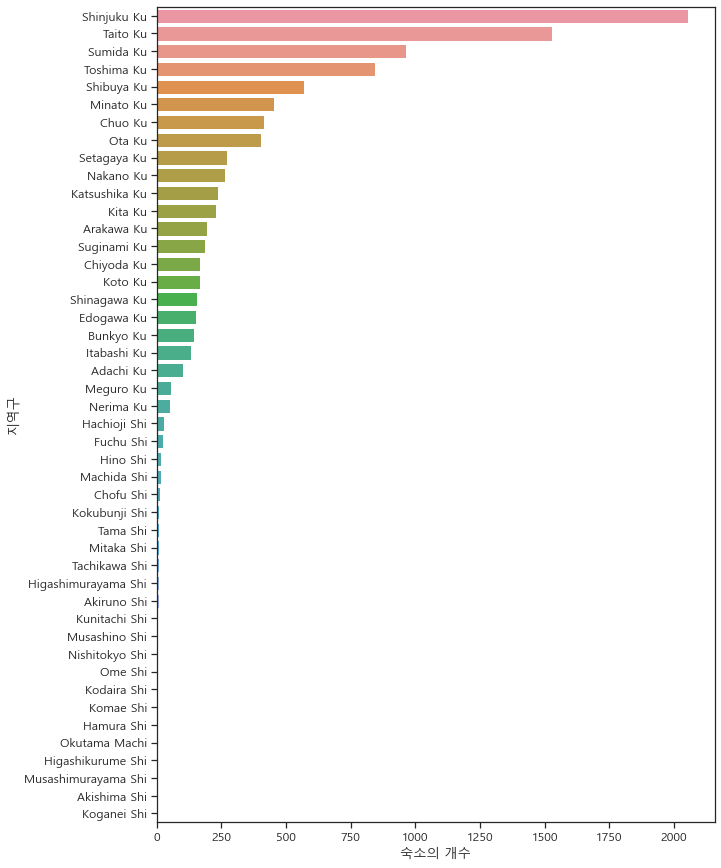

In [762]:
# 지역별 숙소의 개수 시각화 (수평 막대그래프)
neighbourhood_count = pd.DataFrame(tokyo_group_data).reset_index()
neighbourhood_count = neighbourhood_count.sort_values(by="id", ascending=False)
plt.figure(figsize=(10,15))
ax = sns.barplot(x= "id", y = "neighbourhood_cleansed",  data = neighbourhood_count)
ax.set(xlabel='숙소의 개수', ylabel='지역구')
plt.show()

In [763]:
# 도쿄도 23구 가 아닌 시들은 데이터가 너무 적음 분석에서 제외
df["is_Ku"] = df["neighbourhood_cleansed"].apply(lambda x : True if "Ku" == x.split()[1] else False)
df = df[df["is_Ku"]]

In [764]:
# 23구의 지역 정보만 따로 저장
with open("data/summary_file/neighbourhoods.geojson",'r') as json_file:             
    tokyo_geo = json.load(json_file)

tokyo_geo_23_Ku = {}
tokyo_geo_23_Ku["type"] = 'FeatureCollection'

features_list = []
for i in tokyo_geo["features"]:
    if i["properties"]["neighbourhood"].split()[1] == "Ku":
        features_list.append(i)
    else:
        pass

tokyo_geo_23_Ku["features"] = features_list

In [765]:
# 23구별 숙소의 평균가격 시각화
latitude, longitude = 35.68333221633855, 139.7653272944707
map = folium.Map(location=[latitude, longitude], 
                zoom_start=11)
with open("data/summary_file/neighbourhoods.geojson",'r') as json_file:             
    tokyo_geo = json.load(json_file)

folium.GeoJson(
    tokyo_geo_23_Ku,
    name='지역구'
).add_to(map)

tokyo_group_data = df.groupby("neighbourhood_cleansed").mean()["price"]

map.choropleth(geo_data=tokyo_geo_23_Ku,
             data=tokyo_group_data, 
             fill_color='YlOrRd', 
             fill_opacity=0.5,
             line_opacity=0.2,
             key_on="properties.neighbourhood",
             legend_name= "neb"
            )

map

C:\Users\havea\anaconda3\envs\cp1\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


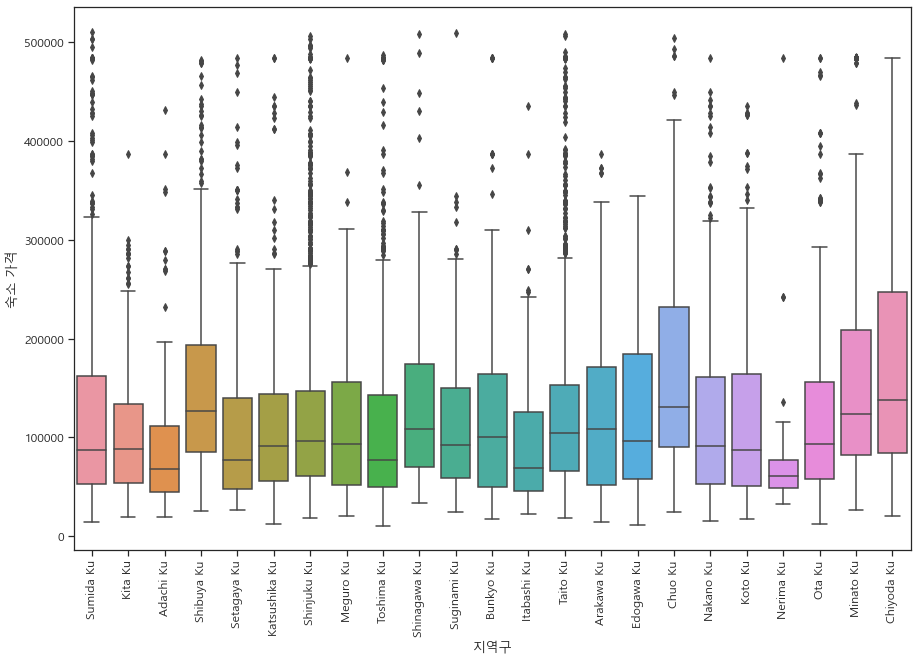

In [766]:
# 지역별 숙소의 개수 시각화 (수평 막대그래프)
neighbourhood_count = pd.DataFrame(tokyo_group_data).reset_index()
neighbourhood_count = neighbourhood_count.sort_values(by="price", ascending=False)
plt.figure(figsize=(15,10))
ax = sns.boxplot(y= "price", x = "neighbourhood_cleansed",  data = df)
ax.set(xlabel='지역구', ylabel='숙소 가격')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

In [767]:
# 상자그림으로 보아 정규성과 등분산성에 문제가 있을수 있다고 판단
# 등분산검정 실시
Ku_list = list(df["neighbourhood_cleansed"].value_counts().index)
data_ = [df.loc[df["neighbourhood_cleansed"] == Ku, "price"].values for Ku in Ku_list]
stats.levene(*data_)
# 등분산 검정의 귀무가설을 기각한다 즉, 등분산이 아니다

LeveneResult(statistic=7.137849312690729, pvalue=3.6022876662851693e-22)

In [768]:
# 등분산이 아니므로 이분산에 강건한 Welch anova 실시
import pingouin as pg
pg.welch_anova(dv='price', between='neighbourhood_cleansed', data=df)
# 귀무가설을 기각한다 지역구별로 숙소 가격의 평균에 차이가 있다.

,Source,ddof1,ddof2,F,p-unc,np2
0,neighbourhood_cleansed,22,1442.148904,13.313446,2.849574e-44,0.032361


In [769]:
# 사후검정 실시
post_hoc = pg.pairwise_gameshowell(dv='price', between='neighbourhood_cleansed', data=df)
vis = pd.pivot_table(post_hoc,values="pval",index="A",columns="B")
columns_list = list(vis.columns)
temp_list = [np.NAN] * vis.shape[0]
vis["Adachi Ku"] = temp_list
vis = vis [["Adachi Ku"] + columns_list]
temp_df = pd.DataFrame([np.NAN]*(vis.shape[1])).T
temp_df.columns = vis.columns
vis = pd.concat([vis, temp_df], axis=0)
vis = vis.rename(index={0 : "Toshima Ku"})# >= 0.05

# 서로 다른 구를 입력하면 유의확률을 반환해주는 함수
def is_significant_pval(area1, area2):
    if area1 == area2:
        raise "서로 다른 지역을 입력하시오"
    else:
        if pd.isna(vis.loc[area1, area2]):
            return vis.loc[area2, area1]        
        else:
            return vis.loc[area1, area2]

# 서로 다른 구를 입력하면 평균의 차이가 유의한지 알려주는 함수
def is_significant(area1, area2):
    if is_significant_pval(area1, area2) < 0.05:
        return f"{area1}과 {area2}의 평균의 차이가 있다."
    else :
        return f"{area1}과 {area2}의 평균의 차이가 없다."    

# 시연
is_significant("Chiyoda Ku", "Adachi Ku")        

'Chiyoda Ku과 Adachi Ku의 평균의 차이가 있다.'

Text(0.5, 1.0, '도쿄역과의 직선거리와 숙소가격의 산점도 및 회귀선')

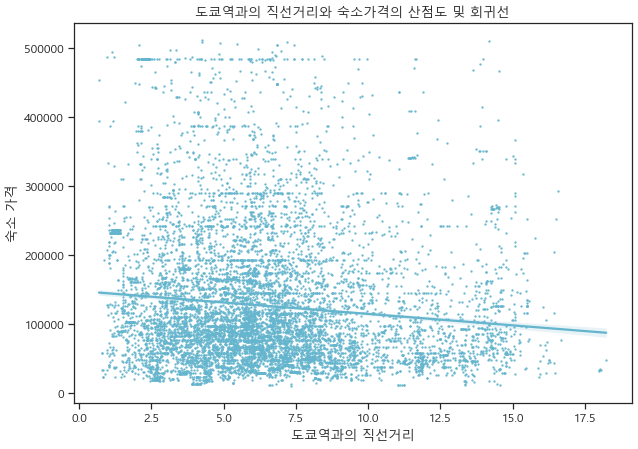

In [770]:
# 두번째 가설
# 중심지(도쿄역)와 숙소의 직선거리와 숙박요금이 선형적인 관계를 가지고 있다.

# 위도와 경도를 기반으로 도쿄역과의 직선거리 생성
tokyo_station_coordinate = (35.681686288521824, 139.76704002247004)

# 숙소의 위치 좌표 생성
df['location'] = list(zip(df['latitude'], df["longitude"]))
df["tokyo_station"] = df["location"].apply(lambda x : haversine(x, tokyo_station_coordinate))

plt.figure(figsize=(10,7))
ax = sns.regplot(x = "tokyo_station", y = "price", scatter_kws={'s':2}, color='c', data =df)
ax.set(xlabel='도쿄역과의 직선거리', ylabel='숙소 가격')
ax.set_title("도쿄역과의 직선거리와 숙소가격의 산점도 및 회귀선")

In [771]:
import statsmodels.api as sm
model = sm.OLS.from_formula("price"+ "~" + "tokyo_station", data=df)
result = model.fit()
print(result.summary())
# 모델의 유의성 검정은 통과할 수 있지만 설명력이 너무 부족하다.

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     116.1
Date:                Mon, 02 May 2022   Prob (F-statistic):           6.33e-27
Time:                        03:21:36   Log-Likelihood:            -1.2556e+05
No. Observations:                9749   AIC:                         2.511e+05
Df Residuals:                    9747   BIC:                         2.511e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.481e+05   2197.712     67.370

Text(0.5, 1.0, '숙소의 수용인원과 숙소가격의 산점도 및 회귀선')

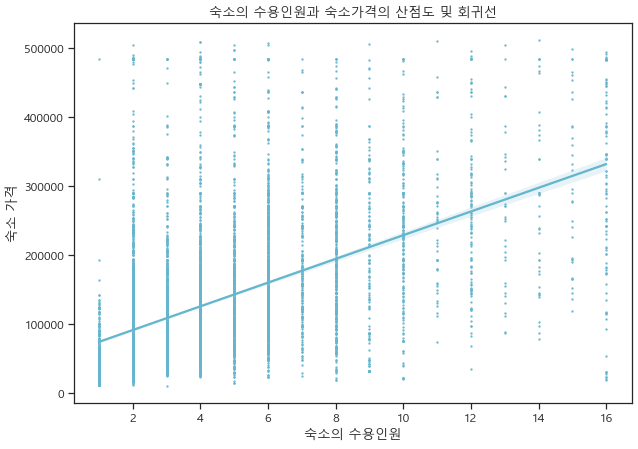

In [772]:
# 이번에는 숙소의 수용인원과 가격의 관계를 확인해보도록한다.
plt.figure(figsize=(10,7))
ax = sns.regplot(x = "accommodates", y = "price", scatter_kws={'s':2}, color='c', data =df)
ax.set(xlabel='숙소의 수용인원', ylabel='숙소 가격')
ax.set_title("숙소의 수용인원과 숙소가격의 산점도 및 회귀선")

In [773]:
import statsmodels.api as sm
model = sm.OLS.from_formula("price"+ "~" + "accommodates", data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     3430.
Date:                Mon, 02 May 2022   Prob (F-statistic):               0.00
Time:                        03:21:36   Log-Likelihood:            -1.2415e+05
No. Observations:                9749   AIC:                         2.483e+05
Df Residuals:                    9747   BIC:                         2.483e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.735e+04   1447.973     39.607   

Text(0.5, 1.0, '표준화 잔차 산점도')

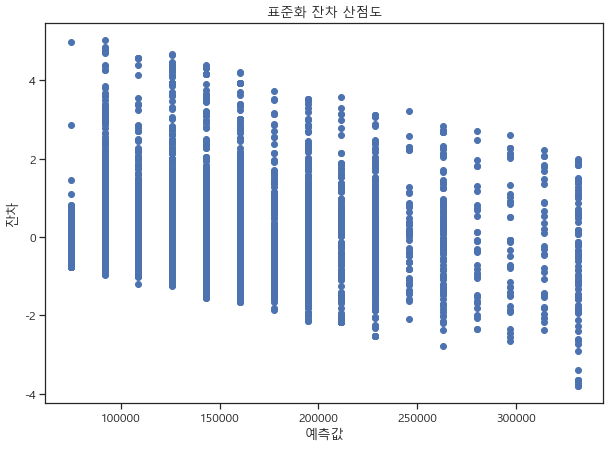

In [774]:
predict = result.params["Intercept"] + result.params["accommodates"] * df["accommodates"]

plt.figure(figsize=(10,7))
plt.scatter(predict , result.resid_pearson)
plt.xlabel("예측값")
plt.ylabel("잔차")
plt.title("표준화 잔차 산점도")

# 잔차의 산점도를 확인해본 결과 새로운 선형항이 추가되면 좋을것으로 판단 -> 단순선형회귀가 아닌 중회귀로 넘어간다.

((array([-3.80432122, -3.57881878, -3.45500028, ...,  3.45500028,
          3.57881878,  3.80432122]),
  array([-312314.62391058, -311347.62391058, -308443.62391058, ...,
          397565.18518583,  409455.38583558,  412771.18518583])),
 (76262.58465581911, 6.119411779709127e-11, 0.9282766192153091))

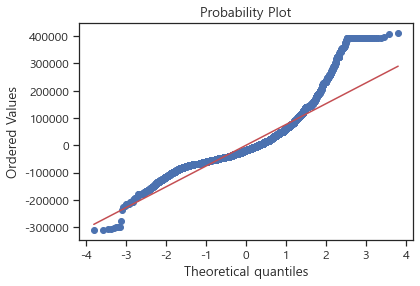

In [775]:
stats.probplot(result.resid ,dist=stats.norm,plot=plt)

In [776]:
# 특성공학을 통해 변수들을 추가로 생성하고 진행한다
df["amenities"] = df["amenities"].apply(lambda x : json.loads(x))
df["no_of_amenities"] = df["amenities"].apply(lambda x : int(len(x)))

In [777]:
# 숙박 요금에 영향을 주는 변수들만 골라서 산점도를 그려보자
var_list = []
for ind_var in df.select_dtypes(include=['float64', 'int64']).columns:
    model = sm.OLS.from_formula("price"+ "~" + ind_var, data=df)
    result = model.fit()
    if result.f_pvalue < 0.05:
        var_list.append(ind_var)      

In [778]:
df = df[var_list]
pd.DataFrame(df.isna().sum() / df.shape[0]).T

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,minimum_nights_avg_ntm,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,tokyo_station,no_of_amenities
0,0.001026,0.001026,0.0,0.0,0.0,0.076726,0.030978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200328,0.201149,0.201149,0.201149,0.0,0.0,0.0,0.0,0.200328,0.0,0.0


In [779]:
# 결측값의 비중이 큰 변수는 사용하지 않는다.
nan_list = ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_value", "reviews_per_month"]
df = df.drop(columns=nan_list)
# 남아있는 소수의 결측값은 제거
df = df.dropna()
for i in nan_list:
    var_list.remove(i)
var_list.remove("price")    



# var_list = var_list.remove("price")
# dfX0 = df[var_list]
# dfX = sm.add_constant(dfX0)
# dfy = pd.DataFrame(df["price"])

# model_boston2 = sm.OLS(dfy, dfX)
# result_boston2 = model_boston2.fit()
# print(result_boston2.summary())#

In [780]:
#중회귀분석
dfX0 = df[var_list]
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(df["price"])

model_boston2 = sm.OLS(dfy, dfX)
result_boston2 = model_boston2.fit()
print(result_boston2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     204.2
Date:                Mon, 02 May 2022   Prob (F-statistic):               0.00
Time:                        03:21:37   Log-Likelihood:            -1.1067e+05
No. Observations:                8739   AIC:                         2.214e+05
Df Residuals:                    8714   BIC:                         2.216e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [781]:
# vif 가 10 이상인 변수를 제거하고 다시 회귀분석 실시
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns

multicollinearity = list(vif[vif["VIF Factor"] > 10]["features"].values)
multicollinearity.remove("const")

for i in multicollinearity:
    var_list.remove(i)
var_list.append("const")
dfX = dfX[var_list]
dfy = pd.DataFrame(df["price"])

model_boston2 = sm.OLS(dfy, dfX)
result_boston2 = model_boston2.fit()
print(result_boston2.summary())    

C:\Users\havea\anaconda3\envs\cp1\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     274.8
Date:                Mon, 02 May 2022   Prob (F-statistic):               0.00
Time:                        03:21:37   Log-Likelihood:            -1.1074e+05
No. Observations:                8739   AIC:                         2.215e+05
Df Residuals:                    8721   BIC:                         2.216e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [782]:
# 여전히 다중공선성이 의심되어서 변수들의 상관계수를 확인해보면 다음과같다.
corr_df = np.abs(dfX.drop("const", axis=1).corr()) > 0.3

In [783]:
corr_df.reset_index()

,index,latitude,longitude,accommodates,bedrooms,beds,maximum_nights,minimum_maximum_nights,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,tokyo_station,no_of_amenities
0,latitude,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,longitude,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,accommodates,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False
3,bedrooms,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False
4,beds,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False
5,maximum_nights,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False
6,minimum_maximum_nights,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False
7,availability_365,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
8,number_of_reviews,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False
9,number_of_reviews_ltm,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False


In [784]:
for i in ["longitude", 'bedrooms', 'beds', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_l30d', 'calculated_host_listings_count_entire_homes']:
    var_list.remove(i)

In [785]:
dfX = dfX[var_list]
dfy = pd.DataFrame(df["price"])

model_boston2 = sm.OLS(dfy, dfX)
result_boston2 = model_boston2.fit()
print(result_boston2.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     450.9
Date:                Mon, 02 May 2022   Prob (F-statistic):               0.00
Time:                        03:21:38   Log-Likelihood:            -1.1080e+05
No. Observations:                8739   AIC:                         2.216e+05
Df Residuals:                    8728   BIC:                         2.217e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

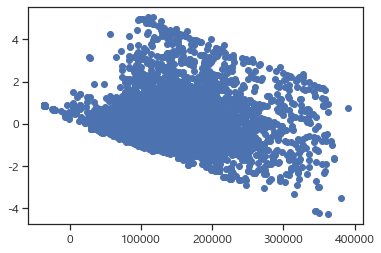

In [786]:
plt.scatter(x = result_boston2.predict(dfX) , y = result_boston2.resid_pearson)

((array([-3.77716009, -3.55013106, -3.4254026 , ...,  3.4254026 ,
          3.55013106,  3.77716009]),
  array([-334968.37341928, -328864.24891616, -322738.81138544, ...,
          386842.62065073,  392506.31519034,  394240.60411078])),
 (73299.44997763734, -3.8226467419423026e-10, 0.9441234561065817))

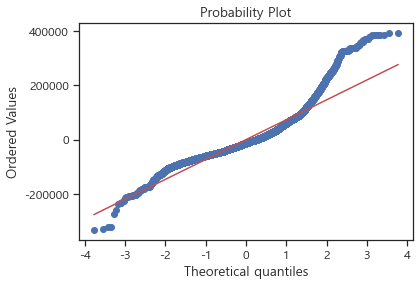

In [787]:
stats.probplot(result_boston2.resid ,dist=stats.norm,plot=plt)